# A minimal plot example
By Florian Ziemen, May 2025

This example uses a `catalog` to load data that is stored online. The data is loaded, turned into a dataset, and then plotted with the healpix library. Some other plots are also illustrated. 

### Load Packages
We need basic packages, intake (for catalogs) and healpix 
Make sure you have the hackathon environment installed. (This may be node specific. Please check with your local host.)

In [1]:
import intake
from easygems import healpix as egh

import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=FutureWarning) # don't warn us about future package conflicts

### Load the catalog
We have one data catalog for the global hackathon, listing our datasets.
But as we have multiple hosting sites, which have some datasets available locally and can access other datasets remotely, the best way to access data may be dependent on the location **where analysis code is executed**.
To solve this issue, we have one sub-catalog per hackathon node (the site where analysis code is executed), and an additional `online` catalog, which is available from the public internet. Here's how you can see our currently available sub-catalogs:

In [2]:
list(intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml"))

['CN', 'EU', 'JAPAN', 'NCAR', 'NERSC', 'UK', 'online']

In normal operation, you would **not** want to load this entire top-level catalog, but instead directly select the catalog appropriate for your location:

In [3]:
current_location = "online"
cat = intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")[current_location]

### List Catalog
list the sources in the catalog:

In [4]:
list (cat)

['ERA5',
 'IR_IMERG',
 'JRA3Q',
 'MERRA2',
 'casesm2_nocumulus',
 'icon_d3hp003',
 'icon_ngc4008',
 'ifs_tco3999-ng5_deepoff',
 'ifs_tco3999-ng5_rcbmf',
 'ifs_tco3999-ng5_rcbmf_cf',
 'nicam_gl11',
 'scream-dkrz',
 'um_Africa_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_CTC_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_SAmer_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_SEA_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_glm_n1280_CoMA9_TBv1p2',
 'um_glm_n1280_GAL9',
 'um_glm_n2560_RAL3p3']

### Pick a Data Set
Use `.describe()` on a dateset to see the other parameter options (we use `pandas` just for concise output formatting)

In [5]:
import pandas as pd

pd.DataFrame(cat["icon_d3hp003"].describe()["user_parameters"])

,name,description,type,allowed,default
0,time,time resolution of the dataset,str,"[PT1H, PT3H, PT6H, P1D]",P1D
1,time_method,time subsetting method,str,"[mean, inst]",mean
2,zoom,zoom resolution of the dataset,int,"[9, 8, 7, 6, 5, 4, 3, 2, 1, 0]",0


### Load Data into a Data Set
most datasets have a `zoom` parameter. We will use `zoom` level 7 [(~50km)](https://easy.gems.dkrz.de/Processing/healpix/index.html#healpix-spatial-resolution)

In [6]:
ds = cat["icon_d3hp003"](zoom=7).to_dask() 
ds

<xarray.Dataset> Size: 98GB
Dimensions:        (time: 425, cell: 196608, crs: 1, pressure: 30,
                    soil_level: 5, pressure_rva: 3)
Coordinates:
  * crs            (crs) float32 4B nan
  * pressure       (pressure) int64 240B 5 10 20 50 ... 92500 95000 97500 100000
  * pressure_rva   (pressure_rva) int64 24B 16 18 23
  * soil_level     (soil_level) int64 40B 0 0 0 2 6
  * time           (time) datetime64[ns] 3kB 2020-01-02 ... 2021-03-01
Dimensions without coordinates: cell
Data variables: (12/58)
    clivi          (time, cell) float32 334MB ...
    clt            (time, cell) float32 334MB ...
    clwvi          (time, cell) float32 334MB ...
    egpvi          (time, cell) float32 334MB ...
    einvi          (time, cell) float32 334MB ...
    ekhvi          (time, cell) float32 334MB ...
    ...             ...
    ua             (time, pressure, cell) float32 10GB ...
    uas            (time, cell) float32 334MB ...
    va             (time, pressure, cell) float32 10GB ...
    vas            (time, cell) float32 334MB ...
    wa             (time, pressure, cell) float32 10GB ...
    zg             (time, pressure, cell) float32 10GB ...

### Plot data on a map

See the [plotting with cartopy example of easy.gems for more details](https://easy.gems.dkrz.de/Processing/healpix/healpix_cartopy.html).

<Figure size 640x480 with 0 Axes>

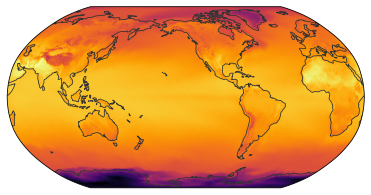

In [7]:
egh.healpix_show(ds["ts"].sel(time="2020-05-10T00:00:00"), cmap="inferno", dpi=72)

### Plot a Zonal Mean

See [Time space diagrams on easy.gems for more info on selecting regions and grouping by lat/lon](https://easy.gems.dkrz.de/Processing/healpix/time-space.html).

Best to do this at lower resolution to reduce data volumes. Always take the lowest resolution that does the job. If in doubt, start with `zoom=0` and work your way up. Low zoom levels are fast to load and plot.

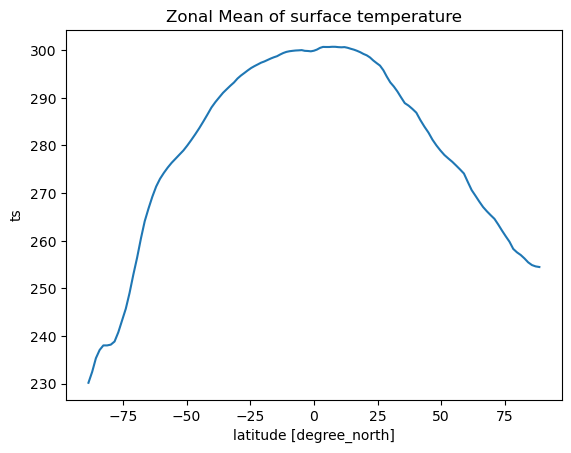

In [8]:
ds = cat["icon_d3hp003"](zoom=5).to_dask() 
# For this analysis, we'll need lat and lon coordinates, here's a way to attach them to the dataset:
ds = ds.rename_dims({'value': 'cell'}).pipe(egh.attach_coords) if 'value' in ds.dims else ds.pipe(egh.attach_coords)

var="ts"
long_name = ds[var].attrs.get("long_name", var)

zm = (
    ds[var]
    .groupby("lat")
    .mean()
).compute()

zm.mean(dim='time').plot()
plt.title(f"Zonal Mean of {long_name}");

### Hovmuller Plot
A similar logic can bin by longitudes over a range of latitudes to make a hovemuller plot in time...

Again, see [Time space diagrams on easy.gems for more](https://easy.gems.dkrz.de/Processing/healpix/time-space.html).

In [10]:
var="rlut"
long_name = ds[var].attrs.get("long_name", var)

Slim, Nlim = 15.0, 35.0
da_by_lon = (
    ds[var]
    .where((ds["lat"] > Slim) & (ds["lat"] < Nlim),drop=True)
    .groupby("lon")
    .mean()
).compute()

Now Plot...

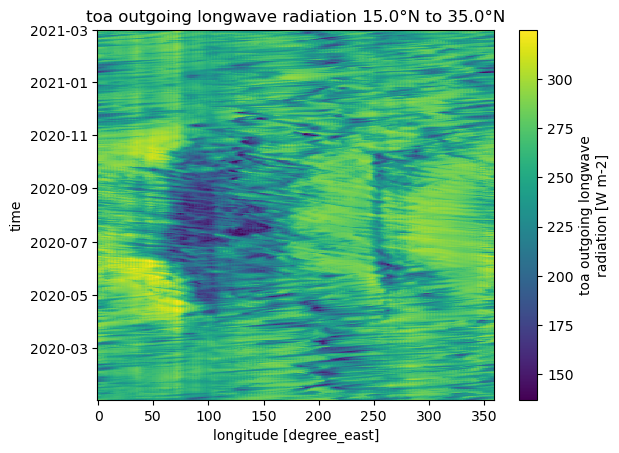

In [11]:
da_by_lon.plot()

latstr=f"{Slim}°N to {Nlim}°N"
plt.title(long_name+" "+latstr);